Restarted default_env (Python 3.12.0)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyabf
import ephys_analysis.funcs_plot_intrinsic_props as pl_intr
import ephys_analysis.funcs_human_characterisation as hcf
from ephys_analysis.funcs_plotting_raw_traces import plot_trace
plt.style.use('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/style_plot_paper.mplstyle')


In [4]:
data_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/human/'+\
    'paper_figs_collected_checked/data/'
work_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/data_verji/'

### REPATCH

In [5]:
df_repatch = pd.read_excel(data_dir + 'repatch_data_temporal.xlsx')
df_r = df_repatch

In [6]:
df_r = df_repatch[df_repatch['treatment'] == 'high K']

mask = (df_r['rheo_ramp_c'] > df_r['rheo_ramp_c'].mean() - df_r['rheo_ramp_c'].std()) & \
(df_r['rheo_ramp_c'] < df_r['rheo_ramp_c'].mean() + df_r['rheo_ramp_c'].std()) & \
(df_r['TH'] < df_r['TH'].mean() + df_r['TH'].std()) & \
(df_r['TH'] > df_r['TH'].mean() - df_r['TH'].std())
df_r = df_r[mask]
        
print(df_r.cell_ID_new.unique())

['vm24411S2c1' 'vm24215S2c1' 'vm24215S2c5' ... 'vm24503S3c8' 'vm24221S1c3'
 'vm24n20S2c3']


In [7]:
# cell_ID = 'vm24321S2c8' # Ctrl first choice, delete the artifact
# cell_ID = 'vm23314S4c7' # Ctrl 2nd choice need to delete the artifact
# cell_ID = 'vm24926S4c1' # 1st candidate for high K
# cell_ID = 'vm23209S2c6' # 2nd candidade for high K

df_r = df_repatch[df_repatch['cell_ID_new'] == cell_ID]

params = ['TH', 'rheo_ramp_c', 'resting_potential', 'sag', 'Rin']

for day in df_r.day.unique():
    df_day = df_r[df_r.day == day]
    print(df_r.cell_ID_new[df_r.day == day])
    for param in params:
        #print(df_day.treatment.values)
        print(f'{day, param, df_day[param].values}')
        #df.cell_ID_new.iloc[indx_ctrl[0] : indx_ctrl[1]]

NameError: name 'cell_ID' is not defined

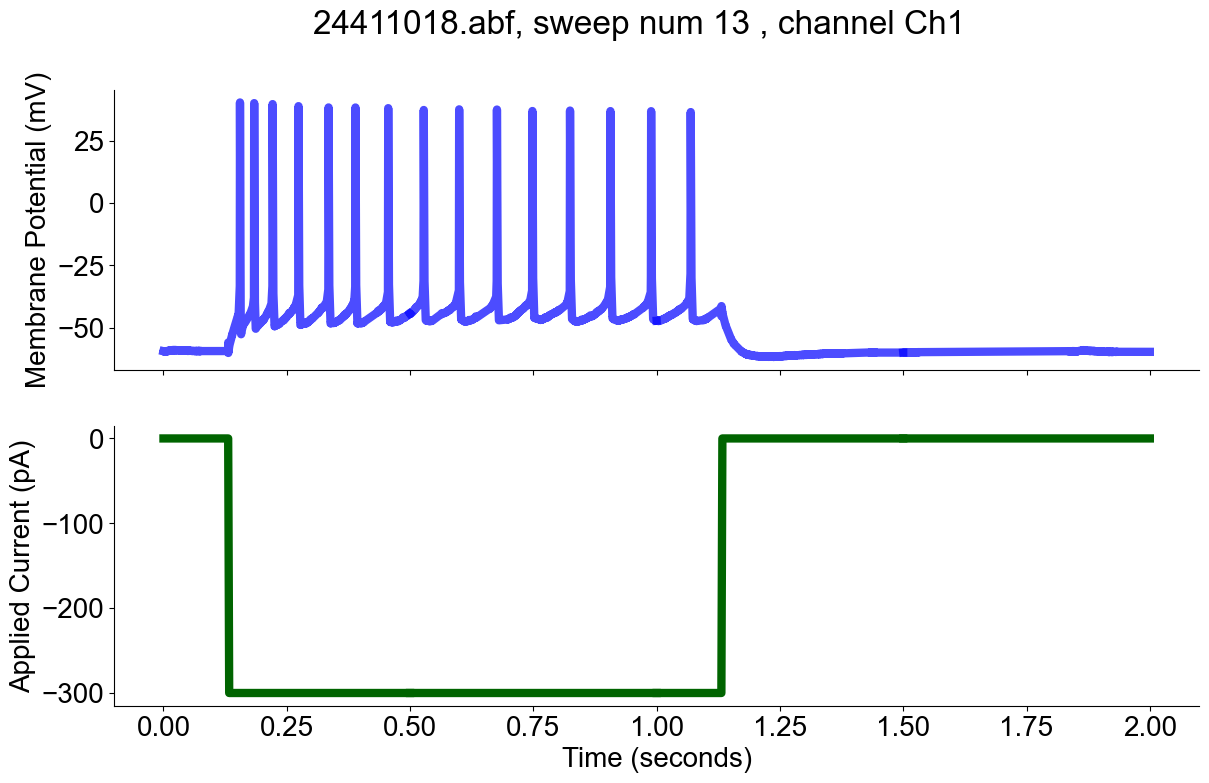

In [8]:
fn1 = work_dir + df_r.OP.values[0] + '/' + df_r.filename.values[0]
plot_trace(fn1, 13, df_r.cell_ch.values[0])

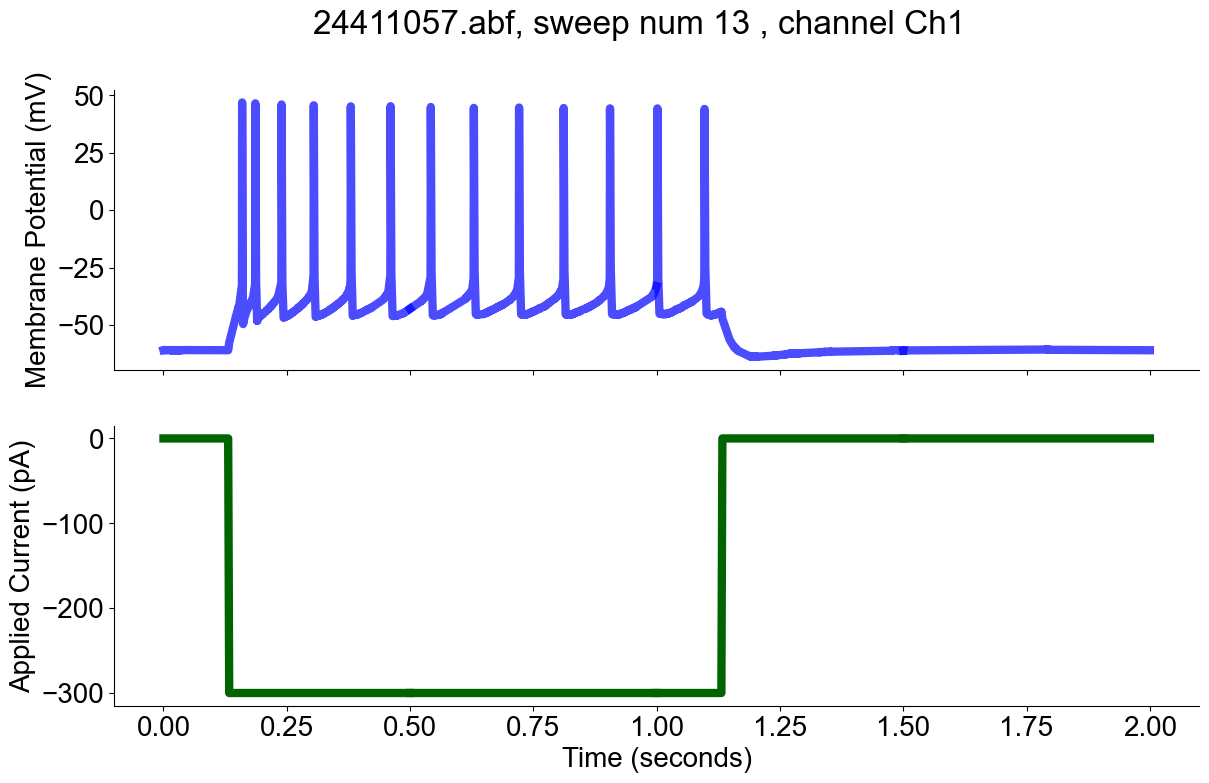

In [9]:
work_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/data_verji/'
fn1 = work_dir + df_r.OP.values[1] + '/' + df_r.filename.values[1]
plot_trace(fn1, 13, df_r.cell_ch.values[1])

In [18]:
# cell_ID = 'vm24926S4c1' # 1st candidate for high K
# cell_ID = 'vm24321S2c8' # Ctrl first choice, delete the artifact
cell_IDs = ['vm23314S4c7', 'vm24411S2c1'] # repatch
data_type = 'repatch'
df_plot = df_repatch[df_repatch['cell_ID_new'].isin(cell_IDs)]

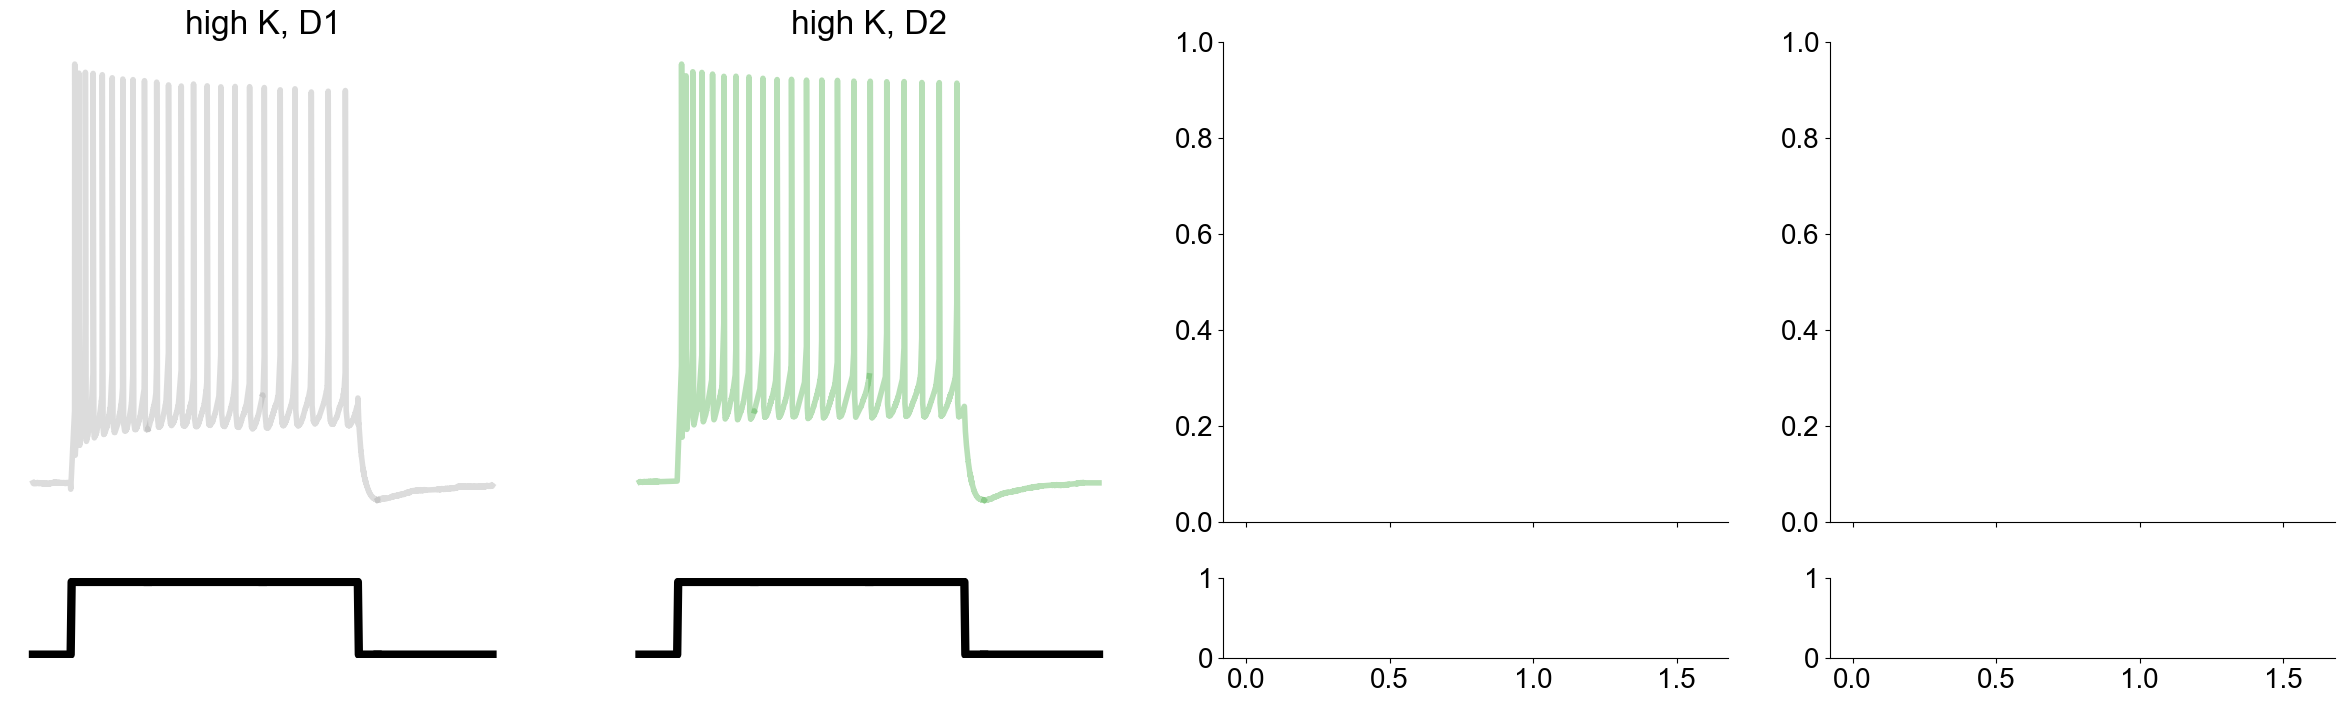

In [27]:
df_plot = df_plot.sort_values(['treatment', 'day']).reset_index(drop=True)


colors = pl_intr.get_color_dict(df_plot.treatment.unique())
swps = [17] # [9, 13, 17]

fig, ax = plt.subplots(2, 4, sharex = True, figsize = (30,8) , \
                       gridspec_kw = {'height_ratios': [6, 1]})

# Plot examples traces
for i, treatment in enumerate(df_plot.treatment.unique()):
    for j, day in enumerate(df_plot.day.unique()):
        k = j + 2*i
        df_day = df_plot[(df_plot.treatment == treatment) & (df_plot.day == day)]
        if len(df_day) > 1:
            print('something is wrong')
            break
        fn = work_dir + df_day.OP.values[0] + '/' + df_day.filename.values[0]
        channel = df_day.cell_ch.values[0]
        inj = hcf.get_inj_current_steps(fn)
        trace = pyabf.ABF(fn)

        if len(trace.channelList) < 8:
            if '_Ipatch' in trace.adcNames:
                trace.adcNames[trace.adcNames.index('_Ipatch')] = 'Ch1'
            if 'IN0' in trace.adcNames:
                trace.adcNames[trace.adcNames.index('IN0')] = 'Ch1'
            channel_name = 'Ch' + str(channel)
            channel = trace.channelList[trace.adcNames.index(channel_name)]
        else:
            channel = channel-1
            channel_name = 'Ch' + str(channel+1)

        for sweep in swps:
            trace.setSweep(sweepNumber = sweep, channel = channel)
            ax[0, k].plot(trace.sweepX[:-8000], trace.sweepY[:-8000], \
                          color = colors[treatment + day], linewidth = 4, alpha = 0.4)
            x = trace.sweepX
            y = trace.sweepY

            ax[0, k].set_ylabel(trace.sweepLabelY)
            ax[0, k ].set_title(f'{treatment}, {day}')
            ax[0, k].axis('off')

            stim_inj = np.concatenate((np.zeros(2625), np.repeat(inj[sweep], 20_000), np.zeros(9375)))
            ax[1, k].plot(trace.sweepX [:-8000], stim_inj, linewidth = 6, c = 'black')
            ax[1, k].set_xlabel(trace.sweepLabelX)
            ax[1, k].set_ylabel(trace.sweepLabelC)
            ax[1, k].axis('off')


dest_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/human/paper_figs_collected_checked/figures/draft3_figures/figure_parts/'
plt.savefig(dest_dir + data_type + 'I_O_cureve.svg', \
                format = 'svg', bbox_inches = 'tight', dpi = 1000)

# fig.suptitle('{0}, sweep num {1} , channel {2}'.format(fn[end_fn:], str(sweep),channel_name))

# plt.show()

In [17]:
inj.index(600)

17

In [16]:
9375 / 20

468.75

### SLICE

In [28]:
df_slice = pd.read_excel(data_dir + 'slice_data_temporal.xlsx')
data_type_s = 'slice'

In [29]:
params = ['TH', 'rheo_ramp_c', 'resting_potential', 'sag', 'Rin']

In [30]:
# finding the best cells for Ctrl and high

df_s = df_slice[(df_slice['day'] == 'D2') & (df_slice['treatment'] == 'high K')]

mask = (df_s['rheo_ramp_c'] > df_s['rheo_ramp_c'].mean() - 0.7*df_s['rheo_ramp_c'].std()) & \
(df_s['rheo_ramp_c'] < df_s['rheo_ramp_c'].mean() + 0.7*df_s['rheo_ramp_c'].std()) & \
(df_s['TH'] < df_s['TH'].mean() + 0.7*df_s['TH'].std()) & \
(df_s['TH'] > df_s['TH'].mean() - 0.7*df_s['TH'].std())

df_s = df_s[mask]
        
print(sorted(df_s.cell_ID.unique()))

for col in params:
    print(col, df_s[col].mean())

['23420S2_D2c7', '23n23S2_D2c7', '23n30S2_D2c7', '24926S4_D2c2', '25207S2_D2c7', '25306S1_D2c1']
TH -33.835856119791664
rheo_ramp_c 476.1169816771671
resting_potential -62.872314453125
sag 0.8527055269773408
Rin 55.14414941755526


In [ ]:
cell_ID_d1 = '24201S1c8' # for D1
cell_ID_ctr_d2 = '24117S2_D2c1'
cell_ID_hik_d2 = '23420S2_D2c7' # '25207S2_D2c7' #'23420S2_D2c7'

df_cell = df_slice[df_slice['cell_ID'] == cell_ID]

for day in df_cell.day.unique():
    df_day = df_cell[df_cell.day == day]
    print(df_cell.cell_ID[df_cell.day == day])
    for param in params:
        #print(df_day.treatment.values)
        print(f'{day, param, df_day[param].values}')
        #df.cell_ID_new.iloc[indx_ctrl[0] : indx_ctrl[1]]

NameError: name 'cell_ID' is not defined

In [32]:
fn1 = work_dir + df_cell.OP.values[0] + '/' + df_cell.filename.values[0]

plot_trace(fn1, 0, df_cell.cell_ch.values[0])

NameError: name 'df_cell' is not defined

In [ ]:
cell_IDs = [cell_ID_d1, cell_ID_ctr_d2, cell_ID_hik_d2]

df_plot_s = df_slice[df_slice['cell_ID'].isin(cell_IDs)]

if len(df_plot_s) != len(cell_IDs):
    print('something is wrong')

-300.0
0.0
600.0
-300.0
0.0
600.0
-300.0
0.0
600.0


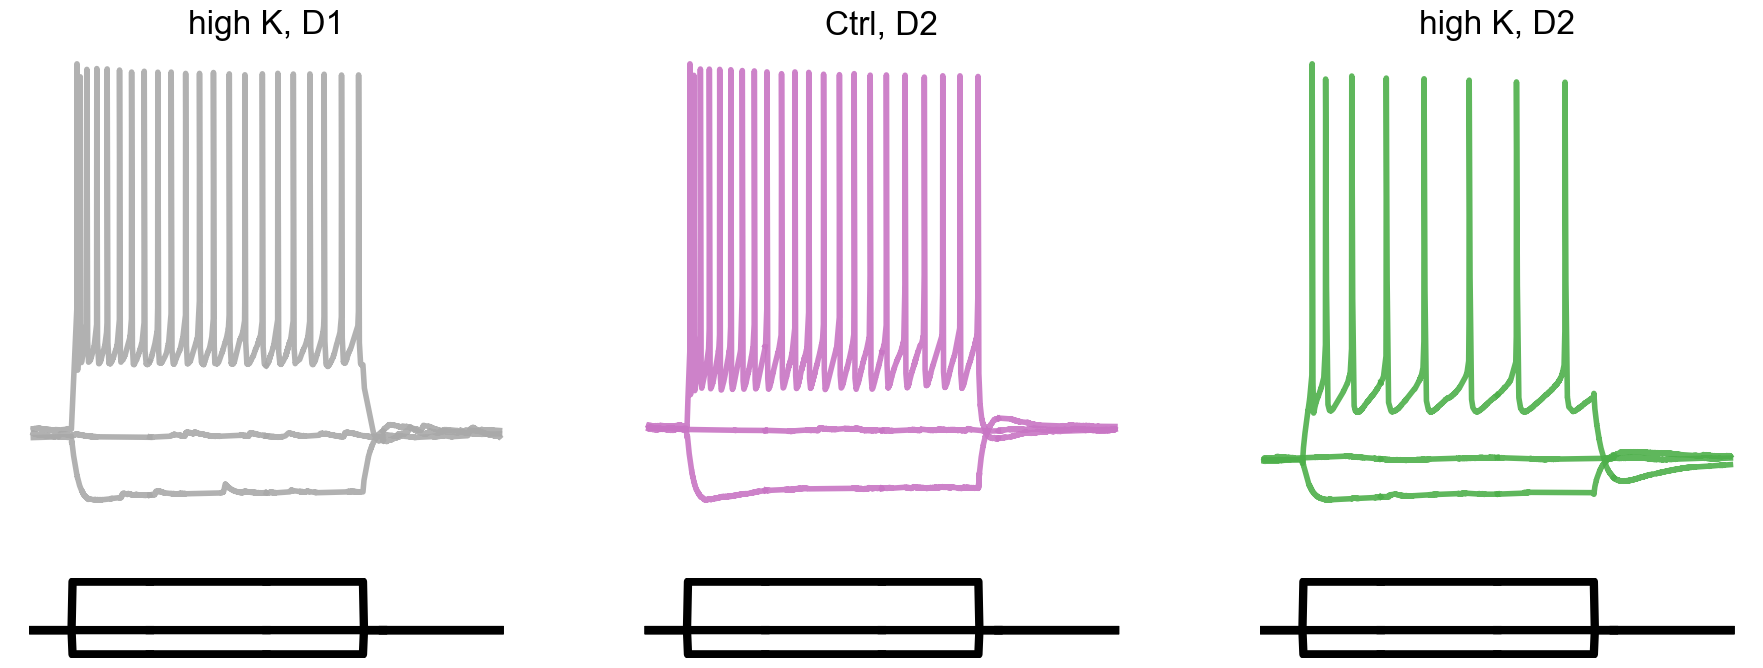

In [ ]:
df_plot_s = df_plot_s.sort_values(['day', 'treatment']).reset_index(drop=True)

colors = pl_intr.get_color_dict(df_plot.treatment.unique())

swps = [9, 13, 17]

fig, ax = plt.subplots(2, 3, sharex = True, figsize = (22.5,8) , \
                       gridspec_kw = {'height_ratios': [6, 1]})

# Plot examples traces
for i, cell in enumerate(cell_IDs):
    df_plot = df_plot_s[df_plot_s['cell_ID'] == cell]
    treatment = df_plot.treatment.values[0]
    day = df_plot.day.values[0]
    fn = work_dir + df_plot.OP.values[0] + '/' + df_plot.filename.values[0]
    channel = df_plot.cell_ch.values[0]
    inj = hcf.get_inj_current_steps(fn)
    trace = pyabf.ABF(fn)

    if len(trace.channelList) < 8:
        if '_Ipatch' in trace.adcNames:
            trace.adcNames[trace.adcNames.index('_Ipatch')] = 'Ch1'
        if 'IN0' in trace.adcNames:
            trace.adcNames[trace.adcNames.index('IN0')] = 'Ch1'
        channel_name = 'Ch' + str(channel)
        channel = trace.channelList[trace.adcNames.index(channel_name)]
    else:
        channel = channel-1
        channel_name = 'Ch' + str(channel+1)

    for sweep in swps:
        trace.setSweep(sweepNumber = sweep, channel = channel)
        ax[0, i].plot(trace.sweepX[:-8000], trace.sweepY[:-8000], \
                        color = colors[treatment + day], linewidth = 4, alpha = 0.9)
        x = trace.sweepX
        y = trace.sweepY

        ax[0, i].set_ylabel(trace.sweepLabelY)
        ax[0, i ].set_title(f'{treatment}, {day}')
        ax[0, i].axis('off')

        stim_inj = np.concatenate((np.zeros(2625), np.repeat(inj[sweep], 20_000), np.zeros(9375)))
        print(inj[sweep])
        ax[1, i].plot(trace.sweepX [:-8000], stim_inj, linewidth = 6, c = 'black')
        ax[1, i].set_xlabel(trace.sweepLabelX)
        ax[1, i].set_ylabel(trace.sweepLabelC)
        ax[1, i].axis('off')


# dest_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/human/paper_figs_collected_checked/figures/draft3_figures/figure_parts/'
# plt.savefig(dest_dir + data_type_s + 'I_O_cureve.svg', \
#                 format = 'svg', bbox_inches = 'tight', dpi = 1000)
            

# fig.suptitle('{0}, sweep num {1} , channel {2}'.format(fn[end_fn:], str(sweep),channel_name))

# plt.show()

### OTHER

In [ ]:
# SEE HOW THE IFF/ NUM_APS PLOT LOOKS

data__type = 'repatch',
dv = 'num_aps'
num_inj_plot = 13

num_aps_indx, iff_indx = pl_intr.get_num_aps_and_iff_data_culumns(df_r)

dv_dict = {'IFF' : [iff_indx, 'Initial firing frequency (AP#1 to AP#2)',  'Instantaneous firing frequency (Hz)'],
'num_aps' : [num_aps_indx, 'Number of fired action potentials', 'AP count']}

fig, ax = plt.subplots(1, len(df_r.treatment.unique()), figsize=(21,8), sharey = True)

for day in df_r.day.unique():
    day_df = df_r[df_r['day'] == day]

    avgs, sems, inj = [], [], []
    for i, col in enumerate(dv_dict[dv][0][5:5+num_inj_plot]):
        data = day_df.iloc[:,col]
        
        data.replace(0, np.nan, inplace=True)
        data.replace(int(0), np.nan, inplace=True)
        data.dropna(inplace=True)
        
        x = np.linspace(0.75+i, 1.25+i, len(data))
        ax.scatter(x, data, alpha = 0.7, s = 7)

        avg = np.mean(data)
        sem = np.std(data, ddof=1) / np.sqrt(np.size(data))

        #yerr = np.linspace((avg - sem), (avg + sem), 5)
        ax.errorbar(i + 1, avg, yerr = sem)

        avgs.append(avg)
        sems.append(sem) #standard error of the mean
        inj.append(day_df.columns[col][2:(day_df.columns[col]).rfind('pA')])

    ax.scatter(range(1, len(inj)+1), avgs, label = day, s = 30)
    ax.plot(range(1, len(inj)+1), avgs, label = day)
    #ax[k].errorbar(range(1, len(inj)+1), avgs, yerr = sem, label = day, color = colors[treatment + day])

    ax.set_xlabel('Current (pA)')
    ax.set_ylabel(dv_dict[dv][2])
    ax.set_xticks(ticks = np.arange(1, num_inj_plot, 2), \
                        labels = np.arange(0, 100 * len(np.arange(1, num_inj_plot, 2)), 100),
    rotation = 45)
    # max_val = max(tr_df.iloc[:,dv_dict[dv][0]].max(numeric_only = True))

    if dv == 'num_aps':
        ax.set_yticks(ticks = [0, 10, 20, 30, 40, 50, 60])
        last = 50
    else:
        ax.set_yticks(ticks = [0, 40, 80, 120, 160, 200, 240])
        last = 220